<a href="https://colab.research.google.com/github/caltunay/hmlt_chllng/blob/main/Hamlet_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Construct a report that covers the following three questions. 
# The report is intended to describe your analysis and 
# present your results for a mixed technical audience.

# Show the number of lines said per character throughout the play.

# Make a word cloud of unusual words in the script

# Compute the sentiment score for each scene.

hamlet_url = 'https://raw.githubusercontent.com/eliiza/challenge-hamlet/master/hamlet.txt'

# Text Cleaning & Wrangling

In [2]:
import pandas as pd
import numpy as np
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
hamlet = requests.get(hamlet_url).text
hamlet[:500]

'\tHAMLET\n\n\n\tDRAMATIS PERSONAE\n\n\nCLAUDIUS\tking of Denmark. (KING CLAUDIUS:)\n\nHAMLET\tson to the late, and nephew to the present king.\n\nPOLONIUS\tlord chamberlain. (LORD POLONIUS:)\n\nHORATIO\tfriend to Hamlet.\n\nLAERTES\tson to Polonius.\n\nLUCIANUS\tnephew to the king.\n\n\nVOLTIMAND\t|\n\t|\nCORNELIUS\t|\n\t|\nROSENCRANTZ\t|  courtiers.\n\t|\nGUILDENSTERN\t|\n\t|\nOSRIC\t|\n\n\n\tA Gentleman, (Gentlemen:)\n\n\tA Priest. (First Priest:)\n\n\nMARCELLUS\t|\n\t|  officers.\nBERNARDO\t|\n\n\nFRANCISCO\ta soldier.\n\nREYNALDO\tservant to Polonius.\n\tPla'

In [4]:
print(hamlet[:500])

	HAMLET


	DRAMATIS PERSONAE


CLAUDIUS	king of Denmark. (KING CLAUDIUS:)

HAMLET	son to the late, and nephew to the present king.

POLONIUS	lord chamberlain. (LORD POLONIUS:)

HORATIO	friend to Hamlet.

LAERTES	son to Polonius.

LUCIANUS	nephew to the king.


VOLTIMAND	|
	|
CORNELIUS	|
	|
ROSENCRANTZ	|  courtiers.
	|
GUILDENSTERN	|
	|
OSRIC	|


	A Gentleman, (Gentlemen:)

	A Priest. (First Priest:)


MARCELLUS	|
	|  officers.
BERNARDO	|


FRANCISCO	a soldier.

REYNALDO	servant to Polonius.
	Pla


In [5]:
pattern = '\n\t\[[^\]]*\]\n*\tHAMLET\n*ACT.*\n*SCENE.*\n*\t\[[^\]]*\]\n' # matches scene and act starting points -except act 1
pattern_brackets = '\t\[[^\]]*\]|\[[^\]]*\]'# matches prompts in brackets

# split intro and book
book = hamlet[1004:] 
intro = hamlet[:1005]

clean = re.sub(pattern, '', book) # removal of scene entries
clean = re.sub(pattern_brackets, '', clean[70:]) # removal of prompts and choosing starting point at the first line in book

In [6]:
clean = re.sub('\n{5}|\n{4}|\n{3}', '\n\n', clean) # swap 3 or more line breaks with 2 only, to be able to split by character lines 
clean = re.sub('\t\|', '', clean) # clean lines where multiple characters have say simultaneously 
clean_list = clean.split('\n\n') # split for most lines by double line breaks

In [7]:
# baseline for lines per character 

characters = {}

for i in clean_list: # loop over list and count lines of characters and keep dictionary
    character = i.split('\t')[0].upper() # each element ideally contains character and line with a tab delimiter
    if character not in characters: 
        characters[character] = 1
    else:
        characters[character] += 1

# create dataframe for eyeballing top and bottom of dataframe
df_ = pd.DataFrame.from_dict(characters, orient = 'index').reset_index() 
df_.columns = ['character','line_count']

print(df_.sort_values(by = 'line_count', ascending = False).tail())
print('=============')
print(df_.sort_values(by = 'line_count', ascending = False).head())

                                            character  line_count
34                         ROSENCRANTZ  WHAT SAY YOU?           1
35  HAMLET  NAY, THEN, I HAVE AN EYE OF YOU.--IF Y...           1
36               LORD POLONIUS  STILL ON MY DAUGHTER.           1
38         KING CLAUDIUS          O, 'TIS TOO TRUE!\n           1
33   ROSENCRANTZ\n WE'LL WAIT UPON YOU.\nGUILDENSTERN           1
        character  line_count
10         HAMLET         256
5   KING CLAUDIUS          85
8   LORD POLONIUS          79
3         HORATIO          74
0                          63


**- Some lines does not include tab delimiter.**

In [8]:
# fix simultaneous lines by creating 1 line per each of those characters 
# create character and line list 

character = []
lines = []

for line_ in clean_list:
    line = re.split('\t', line_) 
    
    # identify problematic simultaneous lines 
    # split them by line break between
    # add line to both character names 
    if len(line) == 1 and len(re.findall('\w.*\w', line[0])) != 0 and (line[0].split('\n')[0].isupper() and line[0].split('\n')[-1].isupper()) and len(line[0].split('\n')) > 1:
        problem_list = line[0].split('\n')
        character.append(problem_list[0])
        lines.append(problem_list[1])
        character.append(problem_list[-1])
        lines.append(problem_list[1])
    # if not a simultaneous line, add tab delimeter output to character and lines lists  
    else:
        character.append(line[0])
        lines.append(''.join(line[1:]))

print(f'Char list length:\t {len(character)} \nLines list length:\t {len(lines)}')
print(f'\n\nCharacter and Lines length match?: {len(character) == len(lines)}')

Char list length:	 988 
Lines list length:	 988


Character and Lines length match?: True


In [9]:
# create data frame from lists
data = {'chars':character, 'line':lines}
df_ = pd.DataFrame(data)

df_['chars_len'] = df_['chars'].apply(len) # add character name length, to identify and fix where tab delimiter was not enough
df_.sort_values(by = 'chars_len', ascending = True).tail(3)

,chars,line,chars_len
364,LORD POLONIUS How say you by that? Still harp...,daughter: yet he knew me not at first; he said...,56
690,"KING CLAUDIUS My words fly up, my thoughts re...",Words without thoughts never to heaven go.,58
370,"LORD POLONIUS Though this be madness, yet the...","in 't. Will you walk out of the air, my lord?",59


In [10]:
# fix remaining issues in char names
# split char column instances where line is included
pattern = 'HAMLET|HORATIO|LORD POLONIUS|ROSENCRANTZ|KING CLAUDIUS|Danes'

def split_char_line(df_):

    for ind, val in df_.iterrows(): # loop over dataframe

        if val['chars'].find('\n') != -1: # identify and remove line breaks in char column 
            df_.loc[ind, 'chars'] = re.sub('\n', '', val['chars'])

        if val['chars_len']>20: # when line is included to char name, length is over 20
            char = re.findall(pattern, val['chars']) # find character name
            line = ''.join(re.split(pattern, val['chars'])[1:]) # find line by character
            line = line + ' ' + val['line'] # if there's a line existing in line column, append them 

            # fix char and line columns
            df_.loc[ind, 'chars'] = char  
            df_.loc[ind, 'line'] = line
        
        # fix ghost lines
        if val['chars'] == 'Ghost  Swear.':
            df_.loc[ind, 'chars'] = 'Ghost'
            df_.loc[ind, 'line'] = 'Swear.'

        # replace blanks rows in char column with np.nan
        if val['chars'] == '': 
            df_.loc[ind, 'chars'] = np.nan

    # if line is blank, swap with null 
    for ind, val in df_.iterrows():
        if val['line'] == '':
            df_.loc[ind, 'line'] = np.nan

    return df_

df_ = split_char_line(df_)

df_.sort_values(by = 'chars_len', ascending = True).tail(3)

,chars,line,chars_len
364,LORD POLONIUS,How say you by that? Still harping on my\n d...,56
690,KING CLAUDIUS,"My words fly up, my thoughts remain below:\n...",58
370,LORD POLONIUS,"Though this be madness, yet there is method\...",59


**- Lines that are mixed in char column are fixed**

In [11]:
df_.loc[50:53] # there are instances where the line is spread among consecutive rows because of a delimiter included in line

,chars,line,chars_len
50,HORATIO,A mote it is to trouble the mind's eye.\nIn th...,7
51,NaN,"I'll cross it, though it blast me. Stay, illus...",0
52,NaN,"If thou art privy to thy country's fate,\nWhic...",0
53,MARCELLUS,Shall I strike at it with my partisan?,9


In [12]:
# fix above issue by appending all lines with null chars field to its owner 
def merge_lines(df):
    '''takes dataframe, starting iterating from bottom row,
    appends line to above line where, chars field is null
    when chars field is not null, append below cells' to that row and line field'''

    df['line'] = df['line'].replace(np.nan, '') # if line is null, substitute with blank field for appending

    df['chars'] = df['chars'].replace('\s{2}|\n|\:', '', regex = True) # clean chars field for multiple whitespaces
    df['chars'] = df['chars'].str.title() # standardise chars field to lowercase
    
    for i in np.arange(len(df)-1, -1, -1): # loop from end

        if pd.isna(df.loc[i, 'chars']) or df.loc[i,'chars'] == '': # identify null or blanks chars field
            current_line = df.loc[i, 'line'] # take line field of row 
            prev_line = df.loc[i - 1, 'line'] # take line field of rov above 

            replacing_line = prev_line + ' ' + current_line # append them in correct order

            df.loc[i - 1, 'line'] = replacing_line # assign appended line to above cell
    

    return df

In [13]:
df = df_.copy() # keep the original dataframe here efficiency

df.drop(index = 0, inplace = True) # drop first null row manually
df.drop(axis = 1, labels = 'chars_len', inplace = True) # no need for chars_len field anymore
df.reset_index(drop = True, inplace =True) # 

df = merge_lines(df)

print('Previous version\n')
print(df_.loc[884,'line']) 
print('=======\n=======')
print('\nNew version\n')
print(df.loc[883,'line'])

Previous version

How now! what noise is that?

New version

How now! what noise is that? O heat, dry up my brains! tears seven times salt,
Burn out the sense and virtue of mine eye!
By heaven, thy madness shall be paid by weight,
Till our scale turn the beam. O rose of May!
Dear maid, kind sister, sweet Ophelia!
O heavens! is't possible, a young maid's wits
Should be as moral as an old man's life?
Nature is fine in love, and where 'tis fine,
It sends some precious instance of itself
After the thing it loves.


**- Now assigning Acts & Scenes to be able to group by**

In [14]:
a1scene1 = "Who's there?"
a1scene2 = "Though yet of Hamlet our dear brother's death"
a1scene3 = "My necessaries are embark'd: farewell"
a1scene4 = "The air bites shrewdly; it is very cold."
a1scene5 = "Where wilt thou lead me? speak; I'll go no further"

a2scene1 = "Give him this money and these notes, Reynaldo."
a2scene2 = "Welcome, dear Rosencrantz and Guildenstern!"

a3scene1 = "And can you, by no drift of circumstance,"
a3scene2 = "Speak the speech, I pray you, as I pronounced it to"
a3scene3 = "I like him not, nor stands it safe with us"
a3scene4 = "He will come straight. Look you lay home to him:"

a4scene1 = "There's matter in these sighs, these profound heaves"
a4scene2 = "Safely stowed"
a4scene3 = "I have sent to seek him, and to find the body."
a4scene4 = "Go, captain, from me greet the Danish king"
a4scene5 = "I will not speak with her."
a4scene6 = "What are they that would speak with me?"
a4scene7 = "Now must your conscience my acquaintance seal"

a5scene1 = "Is she to be buried in Christian burial that"

scenes = [a1scene1, a1scene2, a1scene3,a1scene4,a1scene5,a2scene1,a2scene2,a3scene1,a3scene2,a3scene3,a3scene4,a4scene1,a4scene2,a4scene3,a4scene4,a4scene5,a4scene6,a4scene7,a5scene1]
scene_tags = ['Act I, Scene I', 
             'Act I, Scene II',
             'Act I, Scene III',
             'Act I, Scene IV',
             'Act I, Scene V',
             'Act II, Scene I',
             'Act II, Scene II',
             'Act III, Scene I',
             'Act III, Scene II',
             'Act III, Scene III',
             'Act III, Scene IV',
             'Act IV, Scene I',
             'Act IV, Scene II',
             'Act IV, Scene III',
             'Act IV, Scene IV',
             'Act IV, Scene V',
             'Act IV, Scene VI',
             'Act IV, Scene VII',
             'Act V, Scene I',]



def act_scene_assign(df):
    """takes in dataframe, iterates over rows,
    if identifes first sentence of any act/scene, 
    marks it by act/scene number in new column 'act_scene'.
    
    after iteretion, forward fills acts, since our dataframe is in same sequence with the book 
    and since lines with null chars field are  appended to it's owner, drops rows, where chars field is null or nan

    resets index to avoid future confusion
    """

    for ind, val  in df.iterrows():
        for scene_line, scene_tag in zip(scenes, scene_tags):
            if len(re.findall(r'^'+scene_line, val['line'])) != 0: 
                df.loc[ind, 'act_scene'] =  scene_tag


    df['act_scene'] = df['act_scene'].ffill() # forward fill acts 
    df['chars'] = df['chars'].replace('', np.nan) # replace chars with nan to drop rows
    df.dropna(how = 'any', axis = 0, inplace = True) # drop rows where  chars field is null
    df.reset_index(drop = True, inplace = True) # reset index

    return df

df = act_scene_assign(df)
df

,chars,line,act_scene
0,Bernardo,Who's there?,"Act I, Scene I"
1,Francisco,"Nay, answer me: stand, and unfold yourself.","Act I, Scene I"
2,Bernardo,Long live the king!,"Act I, Scene I"
3,Francisco,Bernardo?,"Act I, Scene I"
4,Bernardo,He.,"Act I, Scene I"
...,...,...,...
915,First Clown,"Cudgel thy brains no more about it, for your d...","Act V, Scene I"
916,Hamlet,"Has this fellow no feeling of his business, th...","Act V, Scene I"
917,Horatio,Custom hath made it in him a property of easin...,"Act V, Scene I"
918,Hamlet,'Tis e'en so: the hand of little employment ha...,"Act V, Scene I"


# Line Count per Character

**- Counting lines will be easy now**

**- Simply grouping by character and taking count**

In [15]:
# group by character and count instances

line_count = df.groupby(by = 'chars', as_index = False).size().sort_values(by = 'size', ascending = False)

# will also create a pareto chart to see if most of the lines are piled up between a small number of characters 
line_count['pct'] = round(line_count['size'].cumsum() / line_count['size'].sum() * 100)
line_count = line_count.set_index('chars') # set index to chars, for easier plotting

# sanity check
line_count.head(3)

,size,pct
chars,,
Hamlet,265,29.0
King Claudius,87,38.0
Lord Polonius,86,48.0


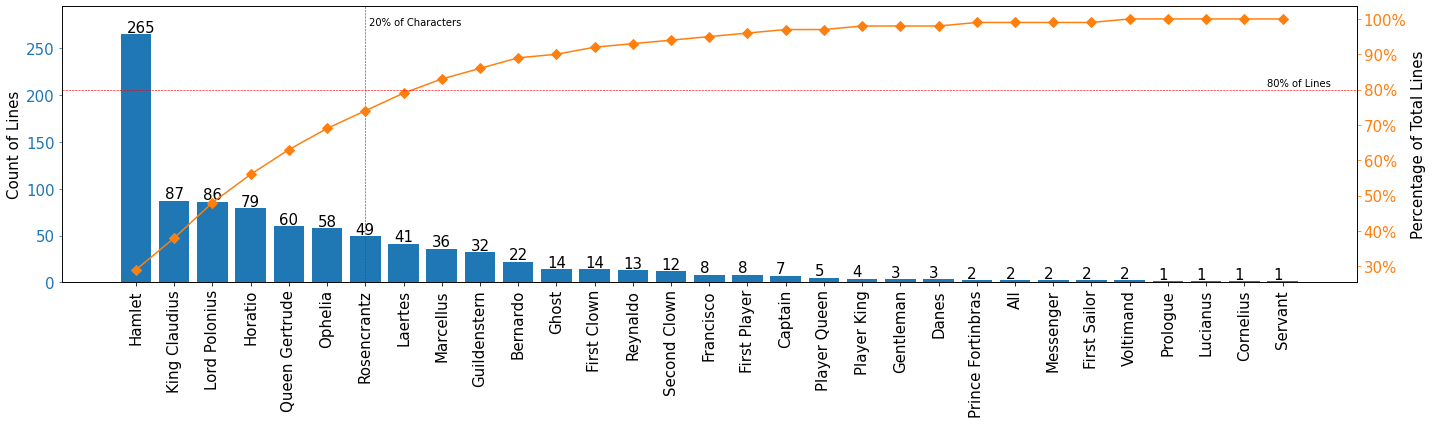

In [16]:
from matplotlib.ticker import PercentFormatter

fig, ax = plt.subplots(figsize=(20,6)) # start object oriented figure

ax.bar(line_count.index, line_count["size"], color="C0") # on ax, create our bar chart with raw count

ax2 = ax.twinx() # start secondary axis

ax2.plot(line_count.index, line_count["pct"], color="C1", marker="D", ms=7) # create line chart, with markers
ax2.yaxis.set_major_formatter(PercentFormatter()) # prettify percentage ticks on axis

# prettify axes
ax.tick_params(axis="y", colors="C0", labelsize = 15)
ax.tick_params(axis = 'x', labelrotation = 90, labelsize = 15)
ax2.tick_params(axis="y", colors="C1", labelsize = 15)
ax.set_ylim(0, 295)

# add pareto lines
# add vertical line at 20% of characters
ax.axvline(x = int(len(line_count)*.2), color = 'r', linestyle = '--', linewidth = .6)
ax.annotate('20% of Characters', xy = (6.1, 275), fontsize = 10)

# add horizontal line at 80% of all lines
ax2.axhline(y = 80, color = 'r', linestyle = '--', linewidth = .6)
ax.annotate('80% of Lines', xy = (29.6, 210), fontsize = 10)

# add data labels for bar chart
for p in ax.patches:
    # print(p)
    ax.annotate(int(p.get_height()),
               xy = (p.get_x()+0.15, p.get_y()+ p.get_height()+2.5),
               fontsize = 15)

# add chart labels
ax.set_ylabel('Count of Lines', fontsize = 15)
ax2.set_ylabel('Percentage of Total Lines', fontsize = 15)
plt.tight_layout()
plt.show()


# Wordcloud of Unusual Words

In [17]:
import nltk

nltk.download('punkt') # to use for cleaning punctuation
nltk.download('stopwords') # to use for cleaning lines from stopwords 
nltk.download('wordnet') # to get a "usual words" dictionary from available words 
nltk.download('words') # to get a "usual words" dictionary from available words
nltk.download('vader_lexicon') # lexicon sentiment analysis
nltk.download('gutenberg') # to get a "usual words" dictionary from available books
nltk.download('movie_reviews') # required to use sentiment analysis

# to use in text cleaning 
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from string import punctuation

import wordcloud 
from wordcloud import ImageColorGenerator # to use coloring from background image

from PIL import Image # wordcloud background image

from textblob import TextBlob # sentiment analysis
from textblob import Blobber # avoid re-training of bayesian framework
from textblob.sentiments import NaiveBayesAnalyzer # sentiment analysis 

from nltk.sentiment.vader import SentimentIntensityAnalyzer # sentiment analysis

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [18]:
# Create a list of 'usual' words
# using books available on gutenberg package
# words list in nltk 

In [19]:
def clean_text(text):
    """takes in text, removes leading, trailing, multiple whitespaces
    standardises letter case, tokenizes words, removes non alpha-numeric elements and lemmatizes words
    removes stopwords, merges into a string again
    """
    text_ = ' '.join(text.split()) # clean leading, traling, multiple whitespaces
    text_ = text_.lower() # standardise cases
    text_ = [token for token in word_tokenize(text_) if token.isalnum()] # tokenize only alpha-numeric and exclude punctuation & special characters
    text_ = [WordNetLemmatizer().lemmatize(token) for token in text_] # lemmatize each word  
    text_ = [token for token in text_ if token not in stopwords.words('english')] # remove stopwords
    text_ = ' '.join(text_)

    return text_

In [20]:
df['clean_line'] = df['line'].apply(clean_text) 

In [21]:
def create_usual_vocabulary():
    """creates a set of vocabulary, combining books in gutenberg books vocabulary
    and nltk words and removing stopwords and punctuation
    """
    nltk_words = nltk.corpus.words.words()
    usual_words_vocab = set(nltk_words)

    for ind in nltk.corpus.gutenberg.fileids(): # loop over author-book name index
        if ind.find('shakespeare') == -1: # if index doesn't contain shakespeare, get words of it 
            words = nltk.corpus.gutenberg.words(ind) # assing in list

            words = [word.lower() for word in words if word.isalnum()] # drop punctuation and special characters
            words = [WordNetLemmatizer().lemmatize(word) for word in words] 
            words = [word for word in words if word not in stopwords.words('english')] # drop stopwords

            usual_words_vocab.update(words) # add to usual words vocabulary set 
            print(f'Added words from book: {ind}') # some sanity check
    
    return usual_words_vocab

usual_words_vocab = create_usual_vocabulary()

Added words from book: austen-emma.txt
Added words from book: austen-persuasion.txt
Added words from book: austen-sense.txt
Added words from book: bible-kjv.txt
Added words from book: blake-poems.txt
Added words from book: bryant-stories.txt
Added words from book: burgess-busterbrown.txt
Added words from book: carroll-alice.txt
Added words from book: chesterton-ball.txt
Added words from book: chesterton-brown.txt
Added words from book: chesterton-thursday.txt
Added words from book: edgeworth-parents.txt
Added words from book: melville-moby_dick.txt
Added words from book: milton-paradise.txt
Added words from book: whitman-leaves.txt


In [22]:
# create single string from cleaned lines 
# remove char names from string, to avoid mentions of characters
# get difference of usual words vocab, to string creating ultimate unusual words used 
# create a counter dictionary for how many times each unusual words are used

def unusual_word_counter():
    """ from cleaned lines, removes character names then words that exist also in usual words vocabulary
    starts a dictionary: counter
    loops through clean lines and counts frequency of each word and returns dictionary
    """

    clean_lines = ' '.join(' '.join(df['clean_line']).split())
    char_names_list = ' '.join(df['chars'].str.lower().unique().tolist()).split()
    clean_lines_set = set(clean_lines.split()).difference(set(char_names_list))
    unusual_words = list(clean_lines_set.difference(usual_words_vocab))

    counter = dict()

    for word in clean_lines.split():
        if word in unusual_words:
            if word in counter.keys():
                counter[word] += 1
            else:
                counter[word] = 1

    return counter

counter = unusual_word_counter()
counter

{'accurst': 1,
 'ancle': 1,
 'baptista': 1,
 'bawdy': 1,
 'beautified': 1,
 'beckons': 1,
 'befitted': 1,
 'behove': 1,
 'bellowed': 1,
 'betime': 1,
 'blastments': 1,
 'bodes': 1,
 'bodykins': 1,
 'brainish': 1,
 'brutus': 1,
 'burthen': 1,
 'caviare': 1,
 'chariest': 1,
 'claudio': 1,
 'clepe': 1,
 'climatures': 1,
 'colleagued': 1,
 'commingled': 1,
 'compell': 1,
 'concernings': 1,
 'congruing': 1,
 'coped': 1,
 'coted': 1,
 'craves': 1,
 'cyclops': 1,
 'daintier': 1,
 'damon': 1,
 'danskers': 1,
 'delated': 1,
 'didest': 1,
 'dido': 1,
 'distilment': 1,
 'divulging': 1,
 'donn': 1,
 'douts': 1,
 'drabbing': 1,
 'droppings': 1,
 'dulls': 1,
 'dumbshows': 1,
 'dupp': 1,
 'eale': 1,
 'elsinore': 4,
 'enactures': 1,
 'enseamed': 1,
 'entreatments': 1,
 'escoted': 1,
 'foh': 1,
 'fordoes': 1,
 'forgone': 1,
 'friending': 1,
 'gaged': 1,
 'gi': 1,
 'gonzago': 4,
 'gyves': 1,
 'havior': 1,
 'hecate': 1,
 'hecuba': 4,
 'hillo': 2,
 'honeying': 1,
 'humourous': 1,
 'hyperion': 2,
 'hyrcani

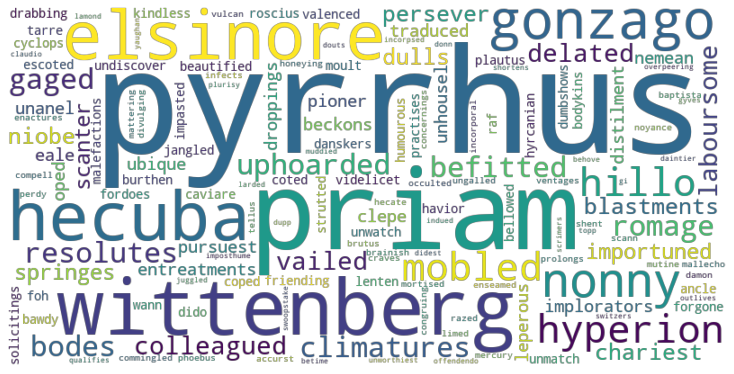

In [23]:
### for running it all at once purposes, commented out mask picture -speech bubble
###################

# mask = np.array(Image.open('/content/bubble3.JPG')) # use default microsoft office speech bubble for wordcloud background 
# image_colors = ImageColorGenerator(mask) # mask to use coloring from speech bubble 

wcloud2 = wordcloud.WordCloud(#mask = mask,
                              width = 800, height = 400,
                              mode = "RGBA", 
                              background_color = None,
                              ).generate_from_frequencies(counter) # create wordcloud using frequencies of usage 
# wcloud2.recolor(color_func = image_colors) 

plt.figure(figsize=(20,5))
plt.imshow(wcloud2, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

wcloud2.to_file('wc.png'); 

# Sentiment Analysis

- There are no labelled lines to take advantage of and use for classifying all lines (by using supervised learning after word embedding, TF-IDF, BoW or some other method)
- Will try commonly used a lexicon frameworks -TextBlob & NLTK-

In [24]:
def act_sentiments(df = df, col = 'clean_line'):
    """takes in dataframe, gets sentiment for each line using textblob and nltk
    assigns sentiment string for line
    outputs 3 dataframes, 
    dataframe with sentiments,
    dataframe with count of textblob sentiments for each act,
    dataframe with count of nltk sentiments for each act  
    """

    tb = Blobber(analyzer=NaiveBayesAnalyzer())
    sid = SentimentIntensityAnalyzer()

    for ind, val in df.iterrows():

        # textblob sentiment
        blob = tb(val[col])
        textblob_sent = blob.sentiment.classification

        if textblob_sent == 'pos':
            textblob_sent = 'Positive'
        elif textblob_sent == 'neg':
            textblob_sent = 'Negative'
        else: 
            textblob_sent = 'Neutral'
        df.loc[ind, 'TextBlob_Sentiments'] = textblob_sent

        # nltk sentiment 
        score = sid.polarity_scores(val[col])['compound']
            
        if score >= 0.05:
            sentiment = 'Positive'
        elif score <= -0.05:
            sentiment = 'Negative'
        else:
            sentiment = 'Neutral'
        
        df.loc[ind, 'NLTK_Sentiments'] = sentiment

        
    textblob_sents_by_scene = df.groupby(by = ['act_scene','TextBlob_Sentiments'], as_index = False).size()
    textblob_sents_by_scene['pct_in_act'] = round(textblob_sents_by_scene.groupby(by = 'act_scene', as_index = False)['size'].apply(lambda x: 100*x / x.sum()).reset_index(drop = True))

    nltk_sents_by_scene = df.groupby(by = ['act_scene','NLTK_Sentiments'], as_index = False).size()
    nltk_sents_by_scene['pct_in_act'] = round(nltk_sents_by_scene.groupby(by = 'act_scene', as_index = False)['size'].apply(lambda x: 100*x / x.sum()).reset_index(drop = True))


    return df, textblob_sents_by_scene, nltk_sents_by_scene

df_sentiments, textblob_by_scenes, nltk_by_scenes = act_sentiments(df)

In [27]:
df_sentiments['chars line act_scene TextBlob_Sentiments NLTK_Sentiments'.split()].sample(10)

,chars,line,act_scene,TextBlob_Sentiments,NLTK_Sentiments
28,Marcellus,"Peace, break thee off; look, where it comes ag...","Act I, Scene I",Positive,Positive
166,Hamlet,What hour now?,"Act I, Scene IV",Negative,Neutral
214,Marcellus,"Lord Hamlet,--","Act I, Scene IV",Positive,Neutral
1,Francisco,"Nay, answer me: stand, and unfold yourself.","Act I, Scene I",Positive,Neutral
221,Hamlet,"O, wonderful!","Act I, Scene IV",Positive,Positive
455,Hamlet,"We'll ha't to-morrow night. You could, for a n...","Act II, Scene II",Positive,Neutral
87,Hamlet,"I would not hear your enemy say so,\nNor shall...","Act I, Scene II",Positive,Negative
725,Hamlet,Do not believe it.,"Act IV, Scene II",Positive,Neutral
446,Lord Polonius,That's good; 'mobled queen' is good.,"Act II, Scene II",Positive,Positive
64,Laertes,"My dread lord,\nYour leave and favour to retur...","Act I, Scene II",Positive,Positive


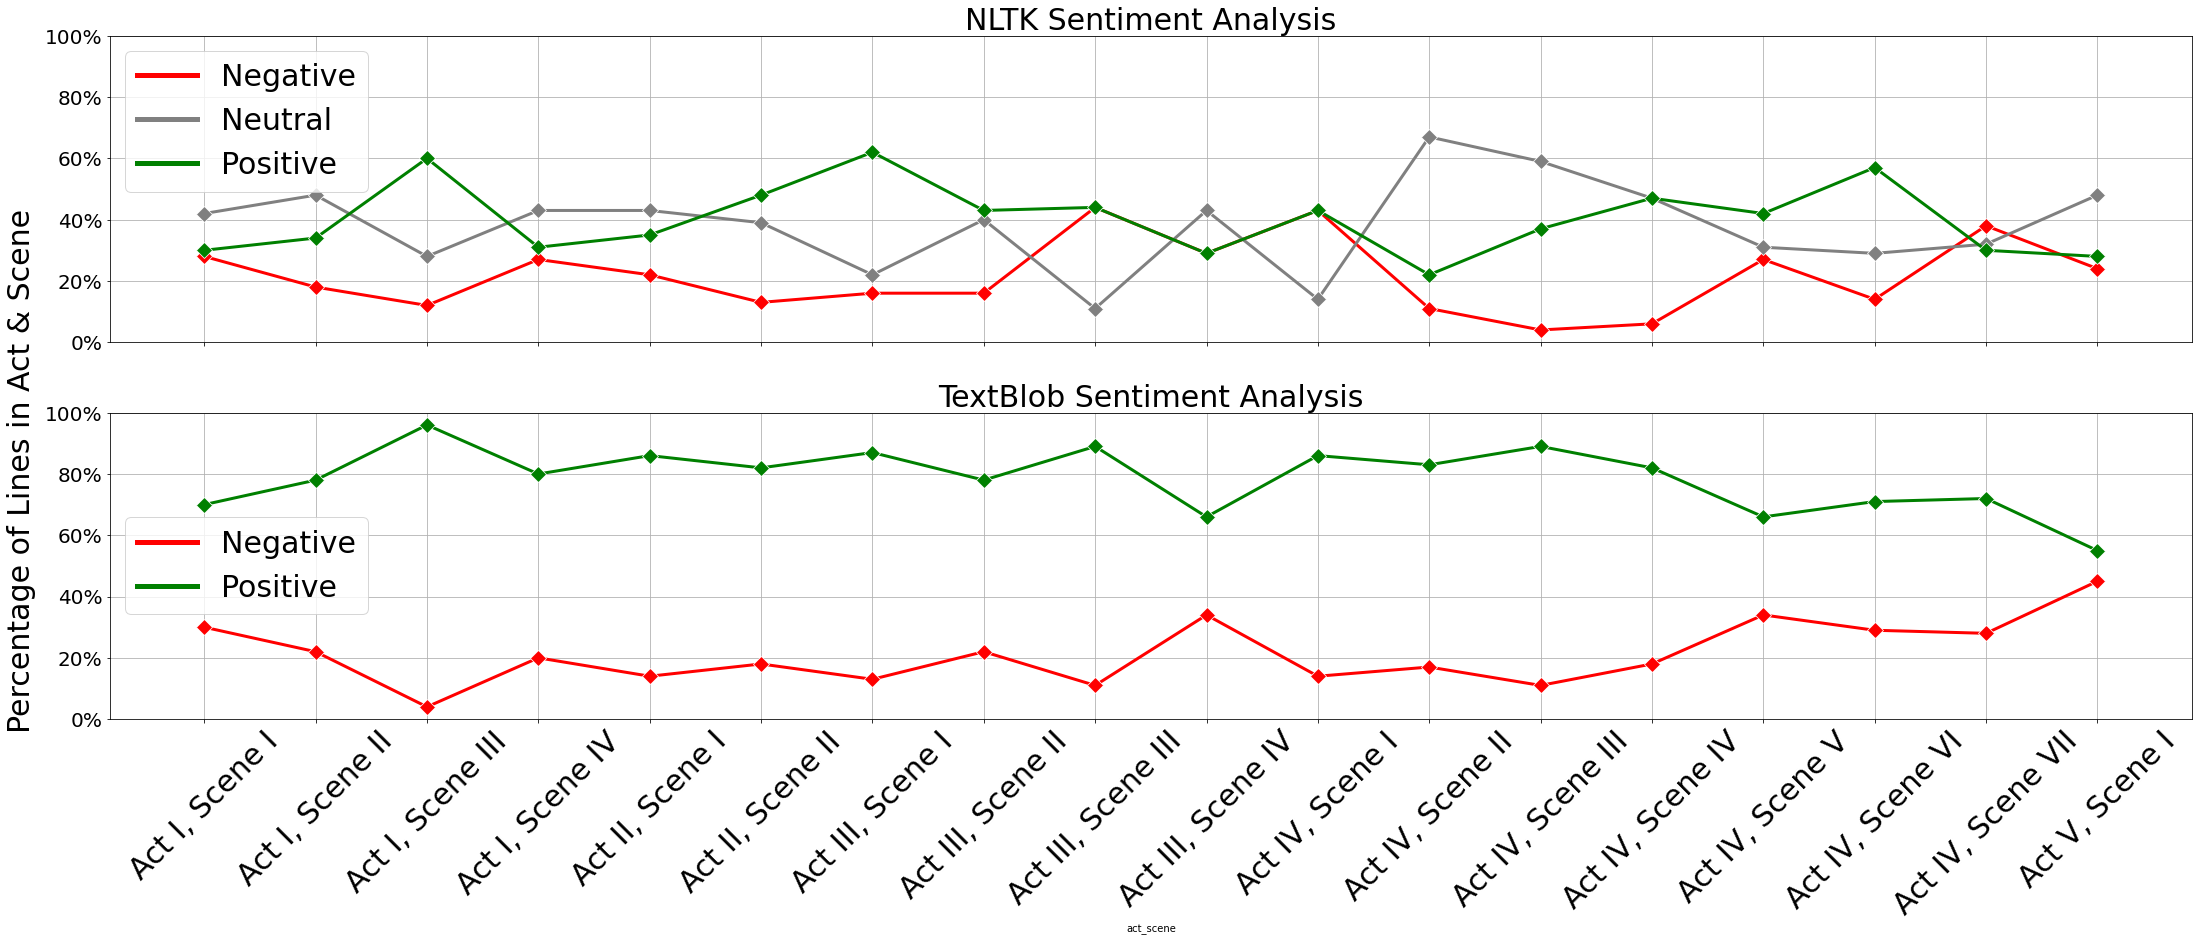

''

<Figure size 432x288 with 0 Axes>

In [26]:
fig, ax = plt.subplots(2, figsize=(31, 14), sharex=True) # create 2 ax plot area

palette ={"Positive": "g", "Neutral": "Grey", "Negative": "r"} # common palette to assign meaningful colours

# nltk plot
g = sns.lineplot(x = 'act_scene', y = 'pct_in_act', data = nltk_by_scenes, hue = 'NLTK_Sentiments', marker = 'D', linewidth = 3, markersize = 12, palette = palette, ax = ax[0]) 

ax[0].set_xticklabels( () ) # remove x ticks from chart on top
ax[0].tick_params(axis = 'y', labelsize = 20) # prettify axis
ax[0].yaxis.set_major_formatter(PercentFormatter(decimals = 0)) # prettify y axis labels

ax[0].set_ylim(0, 100) # standardise y axis with a range of 0 - 100%  
ax[0].yaxis.grid(True, which='major') # add gridlines
ax[0].xaxis.grid(True, which='major') # add gridlines

ax[0].set_title('NLTK Sentiment Analysis', {'fontsize': 30}) # add titles
ax[0].set_ylabel(None) # remove y labels to use 1 shared title for both charts

# place legend to avoid overlapping chart
leg = ax[0].legend(loc='upper left', 
         fontsize = 30,
         markerfirst = True)

# format legend markers for visibility
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

# textblob plot
g1 = sns.lineplot(x = 'act_scene', y = 'pct_in_act', data = textblob_by_scenes, hue = 'TextBlob_Sentiments', marker = 'D', linewidth = 3, markersize = 12, palette = palette, ax = ax[1])

ax[1].tick_params(axis = 'x', labelsize = 30, labelrotation = 45) # prettify axis
ax[1].tick_params(axis = 'y', labelsize = 20) # prettify axis
ax[1].yaxis.set_major_formatter(PercentFormatter(decimals = 0)) # prettify y axis labels 


ax[1].set_ylim(0, 100) # standardise y axis with a range of 0 - 100%  
ax[1].yaxis.grid(True, which='major') # add gridlines
ax[1].xaxis.grid(True, which='major') # add gridlines

ax[1].set_title('TextBlob Sentiment Analysis', {'fontsize': 30}) # add titles
ax[1].set_ylabel(None)  # remove y labels to use 1 shared title for both charts

# place legend to avoid overlapping chart
leg = ax[1].legend(loc='center left', 
         fontsize = 30,
         markerfirst = True)

# format legend markers for visibility
for legobj in leg.legendHandles:
    legobj.set_linewidth(5.0)

# add shared y axis
fig.text(0.001, 0.5, 'Percentage of Lines in Act & Scene', va='center', rotation='vertical', fontsize = 30)

# add padding to avoid overlapping
plt.tight_layout(pad=4, w_pad=55, h_pad=3)
plt.show()

plt.savefig('sent_by_act.jpg')
;